In [1]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda


In [4]:
# Define CNN Backbone
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        f1 = x
        x = self.pool(torch.relu(self.conv2(x)))
        f2 = x
        x = self.pool(torch.relu(self.conv3(x)))
        f3 = x
        return f1, f2, f3

# Define Feature Pyramid Network (FPN) Head
class FPN(nn.Module):
    def __init__(self, num_classes):
        super(FPN, self).__init__()
        self.backbone = BasicCNN()
        self.lat_conv1 = nn.Conv2d(64, 256, kernel_size=1)
        self.lat_conv2 = nn.Conv2d(128, 256, kernel_size=1)
        self.lat_conv3 = nn.Conv2d(256, 256, kernel_size=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.final_conv = nn.Conv2d(256, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        f1, f2, f3 = self.backbone(x)
        p3 = self.lat_conv3(f3)
        p2 = self.upsample(p3) + self.lat_conv2(f2)
        p1 = self.upsample(p2) + self.lat_conv1(f1)
        out = self.final_conv(p1)
        return out.mean([2, 3])

In [5]:
num_classes = 10  # Set the number of classes
model = FPN(num_classes=num_classes).to(device)

In [6]:
model_path = "/kaggle/input/fpn/pytorch/default/1/pretrained_model.pth"  # Replace with your model path
model.load_state_dict(torch.load(model_path, map_location=device))
print("Loaded model weights successfully.")

Loaded model weights successfully.


/tmp/ipykernel_30/2725348991.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [7]:
# Set up for fine-tuning: Reduce the learning rate
fine_tune_lr = 1e-4  # Lower learning rate for fine-tuning
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=fine_tune_lr)
model.to(device)

FPN(
  (backbone): BasicCNN(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lat_conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (lat_conv2): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (lat_conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode='nearest')
  (final_conv): Conv2d(256, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [8]:
fine_tune_epochs = 50  # Adjust based on your dataset size and requirements
batch_size = 16

In [9]:
# Define paths for images
DATASET_PATH = "/kaggle/input/feb-dataset/dataset"  # Replace with your dataset path
LABELS = sorted(os.listdir(DATASET_PATH))  # Alphabetical order is typical
label_to_idx = {label: idx for idx, label in enumerate(LABELS)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

In [10]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        for label in LABELS:
            label_path = os.path.join(root_dir, label)
            for img_name in os.listdir(label_path):
                self.data.append(os.path.join(label_path, img_name))
                self.labels.append(label_to_idx[label])


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
augmentation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [12]:
dataset = CustomDataset(DATASET_PATH, transform=augmentation)
# dataset = CustomDataset(DATASET_PATH)

In [13]:
# Display some images before and after cropping
def display_images(dataset, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    for i in range(num_images):
        img_path = dataset.data[i]
        image = Image.open(img_path).convert("RGB")
        
        # Original image
        axes[0, i].imshow(image)
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        # Center cropped image
        augmentation_test = augmentation(image)
        axes[1, i].imshow(augmentation_test.permute(1, 2, 0))
        axes[1, i].set_title("Center Cropped")
        axes[1, i].axis("off")

    plt.show()

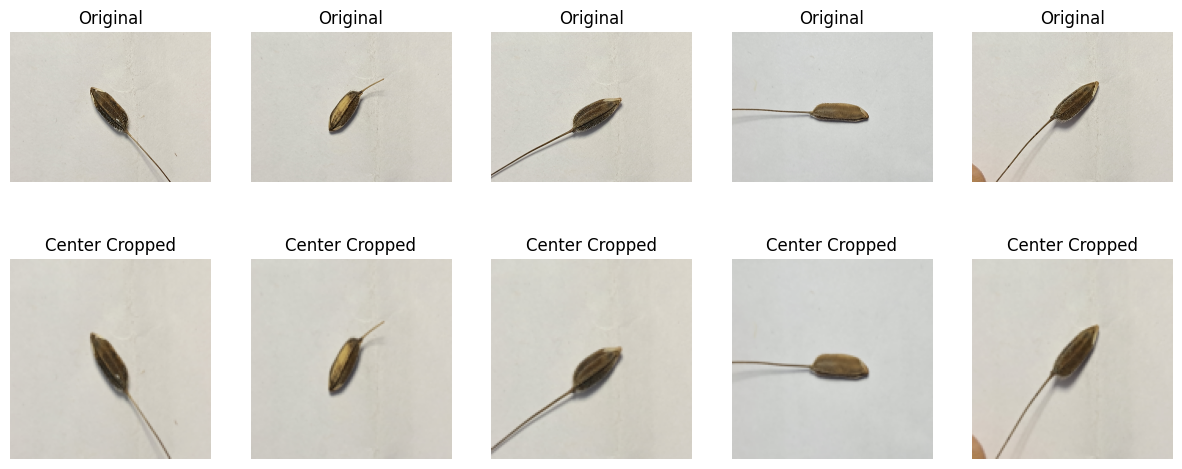

In [14]:
display_images(dataset)

In [15]:
# Load dataset with augmentation for training and testing
# augmented_dataset = CustomDataset(DATASET_PATH, transform=augmentation)

In [16]:
# Split dataset into training and testing sets (80-20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [17]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# Verify that DataLoader and transformations work correctly by displaying a few augmented images
# def display_augmented_images(loader, num_images=5):
#     data_iter = iter(loader)
#     images, labels = next(data_iter)
    
#     fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
#     for i in range(num_images):
#         image = images[i].permute(1, 2, 0).cpu().numpy()
#         axes[i].imshow(image)
#         axes[i].axis("off")
#         axes[i].set_title(f"Label: {LABELS[labels[i].item()]}")

#     plt.show()

# display_augmented_images(train_loader)

In [19]:

for epoch in range(fine_tune_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    # Print average loss for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{fine_tune_epochs}], Loss: {epoch_loss:.4f}")

    # Evaluate on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy after Epoch {epoch+1}: {accuracy:.2f}%")

print("Fine-tuning complete")

Epoch [1/50], Loss: 170.7549
Test Accuracy after Epoch 1: 15.04%
Epoch [2/50], Loss: 17.6890
Test Accuracy after Epoch 2: 23.89%
Epoch [3/50], Loss: 9.3172
Test Accuracy after Epoch 3: 17.99%
Epoch [4/50], Loss: 5.5571
Test Accuracy after Epoch 4: 18.88%
Epoch [5/50], Loss: 4.7185
Test Accuracy after Epoch 5: 21.53%
Epoch [6/50], Loss: 4.4227
Test Accuracy after Epoch 6: 19.47%
Epoch [7/50], Loss: 4.1501
Test Accuracy after Epoch 7: 25.37%
Epoch [8/50], Loss: 3.8784
Test Accuracy after Epoch 8: 22.42%
Epoch [9/50], Loss: 3.7524
Test Accuracy after Epoch 9: 20.35%
Epoch [10/50], Loss: 3.4882
Test Accuracy after Epoch 10: 25.07%
Epoch [11/50], Loss: 3.3111
Test Accuracy after Epoch 11: 26.55%
Epoch [12/50], Loss: 3.1138
Test Accuracy after Epoch 12: 26.55%
Epoch [13/50], Loss: 3.0375
Test Accuracy after Epoch 13: 27.43%
Epoch [14/50], Loss: 2.8389
Test Accuracy after Epoch 14: 30.97%
Epoch [15/50], Loss: 2.6664
Test Accuracy after Epoch 15: 28.32%
Epoch [16/50], Loss: 2.4960
Test Accurac

In [22]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the model is in evaluation mode
model.eval()

all_preds = []
all_labels = []

misclassified = []

# Disable gradient calculation for efficiency
with torch.no_grad():
    for idx in test_dataset.indices:
        img_path = dataset.data[idx]
        image = Image.open(img_path).convert("RGB")
        input_tensor = augmentation(image).unsqueeze(0).to(device)
        label = dataset.labels[idx]
        label_tensor = torch.tensor([label]).to(device)

        output = model(input_tensor)
        _, pred = torch.max(output, 1)

        if pred.item() != label:
            misclassified.append((img_path, label, pred.item()))

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 800x600 with 0 Axes>

In [24]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [25]:
print(len(all_preds), len(all_labels))  # Should both be > 0


339 339


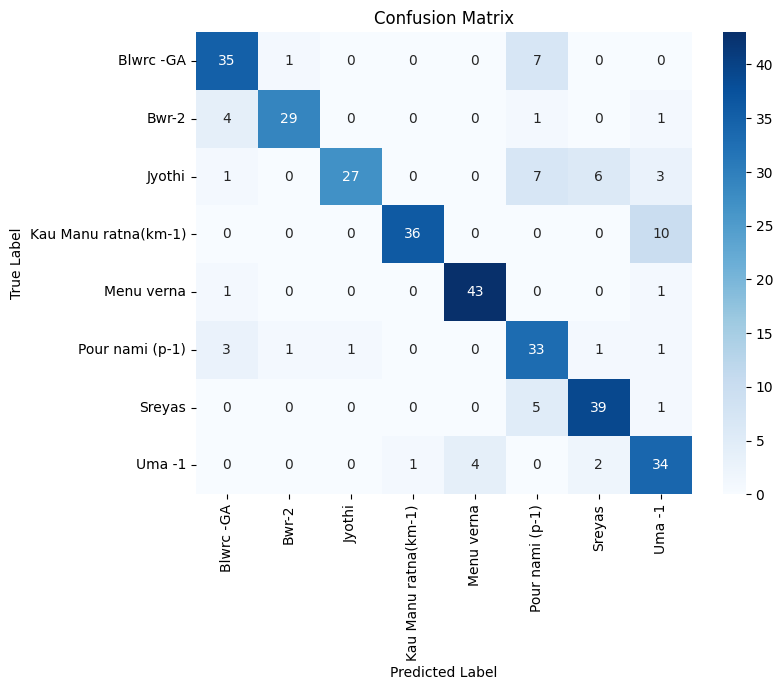

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [21]:
import torch

# Specify the path to save the model
model_save_path = "fpn_model.pth"

# Save only the state dictionary (recommended)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at {model_save_path}")

Model saved at fpn_model.pth



🟥 True: Blwrc -GA → Predicted: Pour nami (p-1)


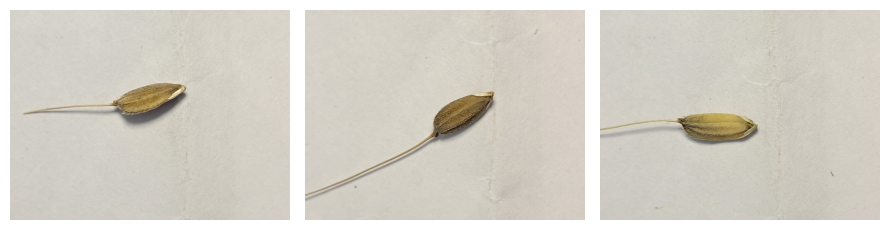


🟥 True: Kau Manu ratna(km-1) → Predicted: Uma -1


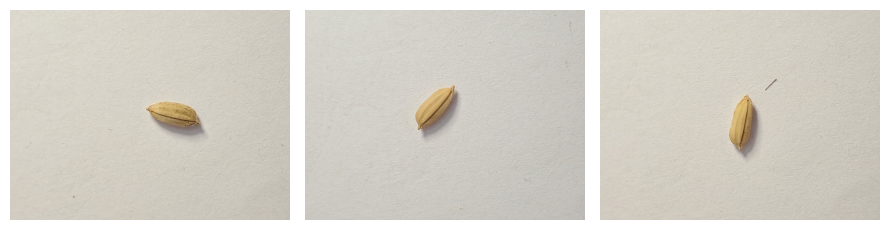


🟥 True: Uma -1 → Predicted: Kau Manu ratna(km-1)


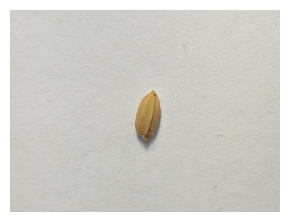


🟥 True: Jyothi → Predicted: Sreyas


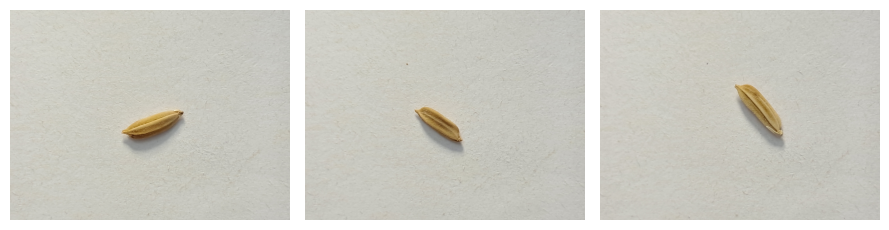


🟥 True: Pour nami (p-1) → Predicted: Blwrc -GA


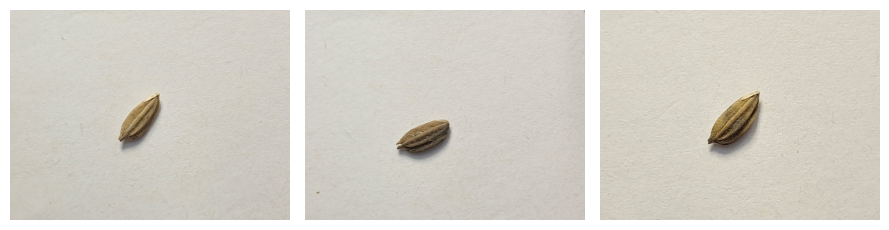


🟥 True: Menu verna → Predicted: Uma -1


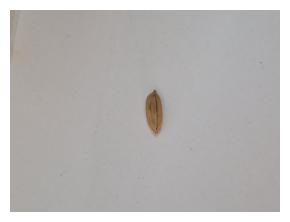


🟥 True: Sreyas → Predicted: Uma -1


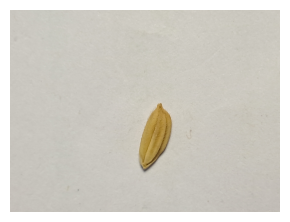


🟥 True: Jyothi → Predicted: Pour nami (p-1)


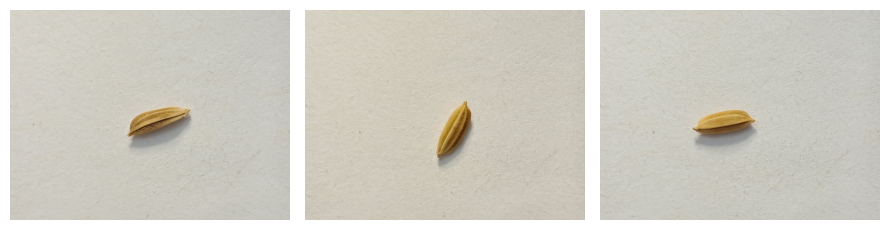


🟥 True: Bwr-2 → Predicted: Blwrc -GA


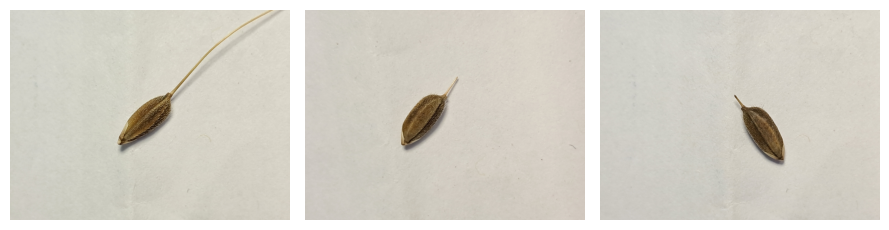


🟥 True: Pour nami (p-1) → Predicted: Bwr-2


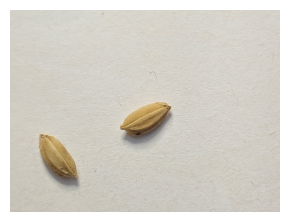


🟥 True: Sreyas → Predicted: Pour nami (p-1)


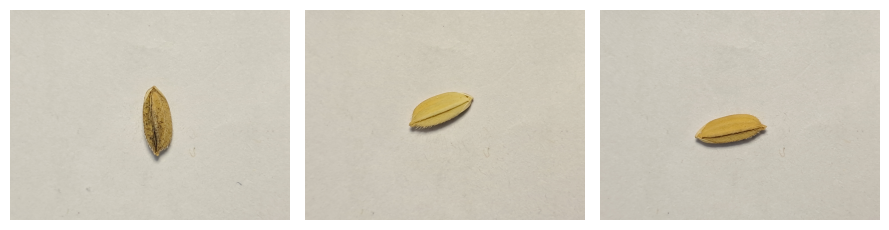


🟥 True: Pour nami (p-1) → Predicted: Sreyas


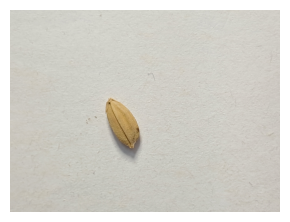


🟥 True: Blwrc -GA → Predicted: Bwr-2


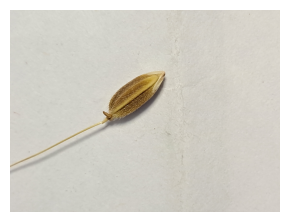


🟥 True: Uma -1 → Predicted: Menu verna


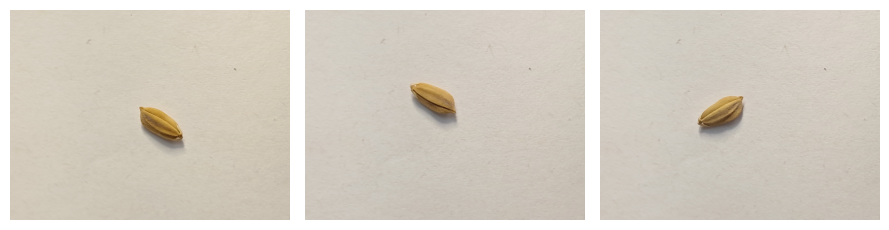


🟥 True: Jyothi → Predicted: Uma -1


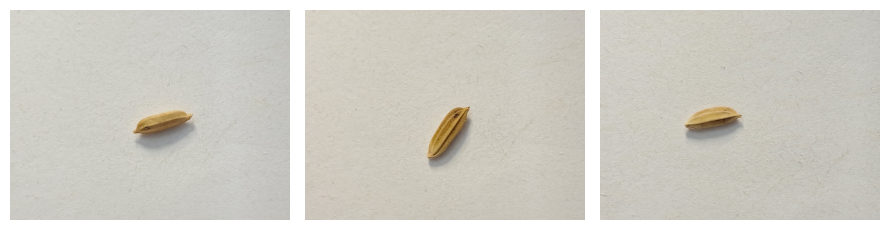


🟥 True: Bwr-2 → Predicted: Pour nami (p-1)


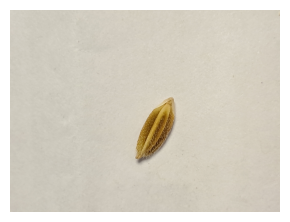


🟥 True: Bwr-2 → Predicted: Uma -1


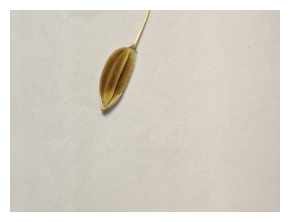


🟥 True: Pour nami (p-1) → Predicted: Jyothi


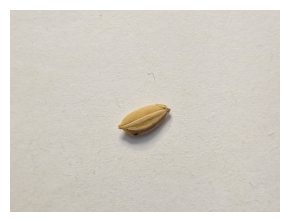


🟥 True: Uma -1 → Predicted: Sreyas


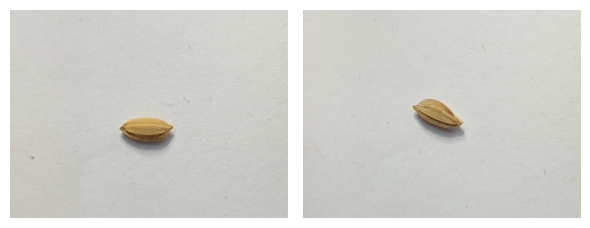


🟥 True: Jyothi → Predicted: Blwrc -GA


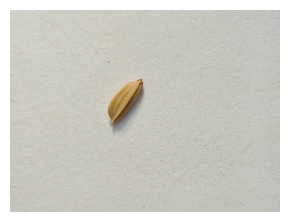


🟥 True: Menu verna → Predicted: Blwrc -GA


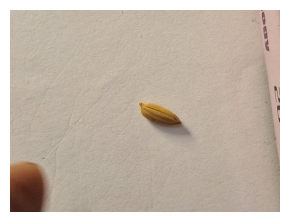


🟥 True: Pour nami (p-1) → Predicted: Uma -1


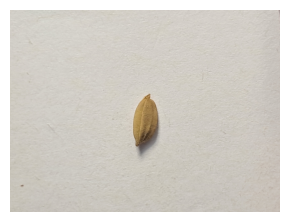

In [28]:
from collections import defaultdict

# Grouping by (true, predicted) pair
misclassified_dict = defaultdict(list)
for path, true_label, pred_label in misclassified:
    misclassified_dict[(true_label, pred_label)].append(path)

# Show a few examples per type of misclassification
def show_misclassifications(misclassified_dict, max_per_type=3):
    for (true_label, pred_label), paths in misclassified_dict.items():
        print(f"\n🟥 True: {idx_to_label[true_label]} → Predicted: {idx_to_label[pred_label]}")
        num_to_show = min(len(paths), max_per_type)
        plt.figure(figsize=(num_to_show * 3, 3))
        for i in range(num_to_show):
            img = Image.open(paths[i]).convert("RGB")
            plt.subplot(1, num_to_show, i + 1)
            plt.imshow(img)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

show_misclassifications(misclassified_dict)

In [27]:
misclassified = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size(0)):
            if preds[j] != labels[j]:
                dataset_idx = test_dataset.indices[i * batch_size + j]  # map from subset to full index
                img_path = dataset.data[dataset_idx]
                true_label = labels[j].item()
                pred_label = preds[j].item()
                misclassified.append((img_path, true_label, pred_label))
